## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import create_interaction_features
from src.features.temporal import create_temporal_features
from src.features.missing_features import MissingValueFeatureEngine, create_missing_value_features
from src.models.lgbm_baseline import LGBMBaseline
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Analyze Original Missing Patterns

In [4]:
# Analyze missing values before feature engineering
print("Analyzing original missing value patterns...\n")

missing_stats = pd.DataFrame({
    'column': train_df.columns,
    'missing_count': train_df.isnull().sum(),
    'missing_pct': train_df.isnull().mean() * 100
}).sort_values('missing_pct', ascending=False)

print("Top 20 columns by missing percentage:")
print("="*60)
for idx, row in missing_stats.head(20).iterrows():
    print(f"{row['column']:20s} {row['missing_count']:8,.0f} ({row['missing_pct']:5.1f}%)")
print("="*60)

Analyzing original missing value patterns...

Top 20 columns by missing percentage:
id_24                 585,793 ( 99.2%)
id_25                 585,408 ( 99.1%)
id_07                 585,385 ( 99.1%)
id_08                 585,385 ( 99.1%)
id_21                 585,381 ( 99.1%)
id_26                 585,377 ( 99.1%)
id_27                 585,371 ( 99.1%)
id_23                 585,371 ( 99.1%)
id_22                 585,371 ( 99.1%)
dist2                 552,913 ( 93.6%)
D7                    551,623 ( 93.4%)
id_18                 545,427 ( 92.4%)
D13                   528,588 ( 89.5%)
D14                   528,353 ( 89.5%)
D12                   525,823 ( 89.0%)
id_03                 524,216 ( 88.8%)
id_04                 524,216 ( 88.8%)
D6                    517,353 ( 87.6%)
id_33                 517,251 ( 87.6%)
id_10                 515,614 ( 87.3%)
Top 20 columns by missing percentage:
id_24                 585,793 ( 99.2%)
id_25                 585,408 ( 99.1%)
id_07               

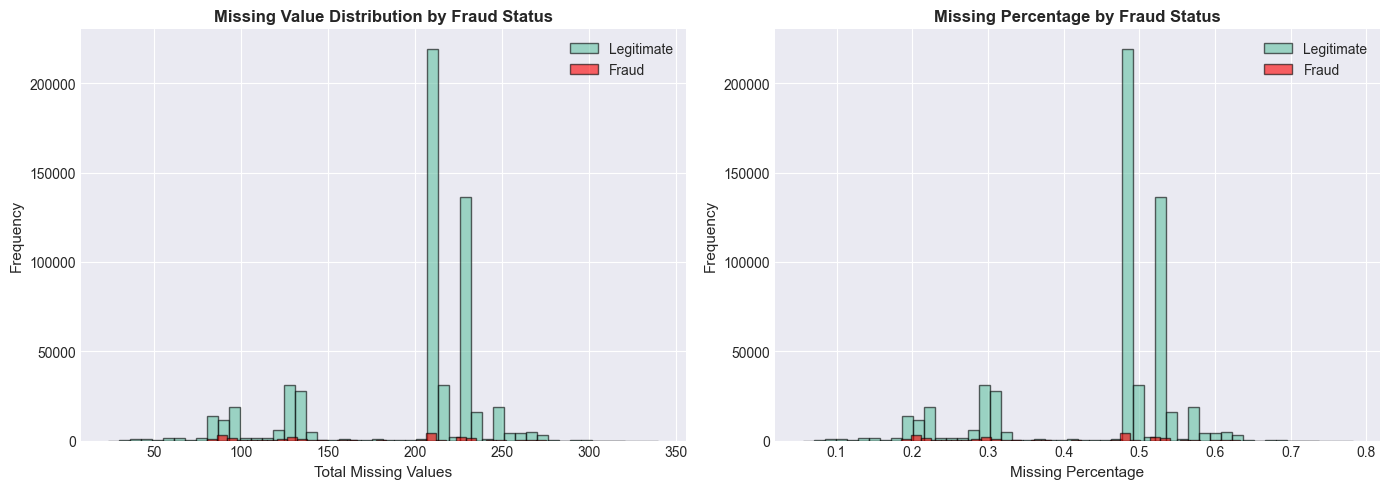

In [5]:
# Visualize missing patterns by fraud status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total missing count distribution
ax = axes[0]
total_missing = train_df.isnull().sum(axis=1)
train_df.loc[train_df['isFraud'] == 0, 'temp_missing'] = total_missing[train_df['isFraud'] == 0]
train_df.loc[train_df['isFraud'] == 1, 'temp_missing'] = total_missing[train_df['isFraud'] == 1]

train_df[train_df['isFraud'] == 0]['temp_missing'].hist(
    bins=50, ax=ax, alpha=0.6, label='Legitimate', edgecolor='black'
)
train_df[train_df['isFraud'] == 1]['temp_missing'].hist(
    bins=50, ax=ax, alpha=0.6, label='Fraud', color='red', edgecolor='black'
)
ax.set_xlabel('Total Missing Values', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Missing Value Distribution by Fraud Status', fontsize=12, fontweight='bold')
ax.legend()

# Missing percentage
ax = axes[1]
missing_pct = total_missing / len(train_df.columns)
train_df.loc[train_df['isFraud'] == 0, 'temp_pct'] = missing_pct[train_df['isFraud'] == 0]
train_df.loc[train_df['isFraud'] == 1, 'temp_pct'] = missing_pct[train_df['isFraud'] == 1]

train_df[train_df['isFraud'] == 0]['temp_pct'].hist(
    bins=50, ax=ax, alpha=0.6, label='Legitimate', edgecolor='black'
)
train_df[train_df['isFraud'] == 1]['temp_pct'].hist(
    bins=50, ax=ax, alpha=0.6, label='Fraud', color='red', edgecolor='black'
)
ax.set_xlabel('Missing Percentage', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Missing Percentage by Fraud Status', fontsize=12, fontweight='bold')
ax.legend()

train_df = train_df.drop(['temp_missing', 'temp_pct'], axis=1)
plt.tight_layout()
plt.show()

## 4. Create Missing Value Features (Milestone 10)

In [6]:
# Create missing value features FIRST (before other feature engineering)
train_df_missing, missing_feature_names = create_missing_value_features(train_df)

print(f"\n✓ Created {len(missing_feature_names)} missing value features")
print(f"Shape: {train_df_missing.shape}")


CREATING MISSING VALUE FEATURES

Creating basic missing value indicators...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 unusual pattern features
Creating missing value interaction features...
  Created 8 unusual pattern features
Creating missing value interaction

## 5. Create Other Features (Milestones 7-9)

In [7]:
# Aggregation features
print("Creating aggregation features...\n")
train_df_agg, agg_feature_names = create_aggregation_features(
    train_df_missing, 
    target_col='TransactionAmt'
)
print(f"✓ Created {len(agg_feature_names)} aggregation features")

# Interaction features
print("\nCreating interaction features...\n")
train_df_inter, interaction_feature_names = create_interaction_features(
    train_df_agg,
    min_samples=10
)
print(f"✓ Created {len(interaction_feature_names)} interaction features")

# Temporal features (without velocity for speed)
print("\nCreating temporal features...\n")
train_df_full, temporal_feature_names = create_temporal_features(
    train_df_inter,
    include_velocity=False
)
print(f"✓ Created {len(temporal_feature_names)} temporal features")

print(f"\nFinal shape: {train_df_full.shape}")
print(f"Total engineered features: {len(missing_feature_names) + len(agg_feature_names) + len(interaction_feature_names) + len(temporal_feature_names)}")

Creating aggregation features...

CREATING ALL AGGREGATION FEATURES

Creating card-based aggregation features...
  • card1 aggregations...
  • card2 aggregations...
  • card2 aggregations...
  • card3 aggregations...
  • card3 aggregations...
  • card4 aggregations...
  • card4 aggregations...
  • card5 aggregations...
  • card5 aggregations...
  • card6 aggregations...
  • card6 aggregations...
  • card1_card2 combination aggregations...
  • card1_card2 combination aggregations...
  ✓ Created 27 card aggregation features
Creating email-based aggregation features...
  • P_emaildomain aggregations...
  ✓ Created 27 card aggregation features
Creating email-based aggregation features...
  • P_emaildomain aggregations...
  • R_emaildomain aggregations...
  • R_emaildomain aggregations...
  • P_email + R_email combination aggregations...
  • P_email + R_email combination aggregations...
  ✓ Created 12 email aggregation features
Creating device-based aggregation features...
  • DeviceType ag

## 6. Analyze Missing Value Features

In [8]:
# Display sample missing features
print("Sample missing value features:\n")
print(f"Total: {len(missing_feature_names)}\n")

# Group by type
basic_features = [f for f in missing_feature_names if 'total_missing' in f]
group_features = [f for f in missing_feature_names if any(x in f for x in ['V_missing', 'C_missing', 'D_missing', 'M_missing', 'id_missing'])]
cooccur_features = [f for f in missing_feature_names if any(x in f for x in ['both_missing', 'one_missing', 'all_present'])]
card_features = [f for f in missing_feature_names if 'card' in f and 'missing' in f]
unusual_features = [f for f in missing_feature_names if any(x in f for x in ['anomaly', 'mismatch', 'unusual', 'critical'])]

print(f"Basic features: {len(basic_features)}")
print(f"Group features: {len(group_features)}")
print(f"Co-occurrence features: {len(cooccur_features)}")
print(f"Card features: {len(card_features)}")
print(f"Unusual pattern features: {len(unusual_features)}")

print("\nSample group features:")
for i, feat in enumerate(group_features[:10], 1):
    print(f"  {i}. {feat}")

Sample missing value features:

Total: 104

Basic features: 2
Group features: 11
Co-occurrence features: 17
Card features: 9
Unusual pattern features: 5

Sample group features:
  1. V_missing_count
  2. V_missing_pct
  3. C_missing_count
  4. C_missing_pct
  5. D_missing_count
  6. D_missing_pct
  7. M_missing_count
  8. M_missing_pct
  9. id_missing_count
  10. id_missing_pct


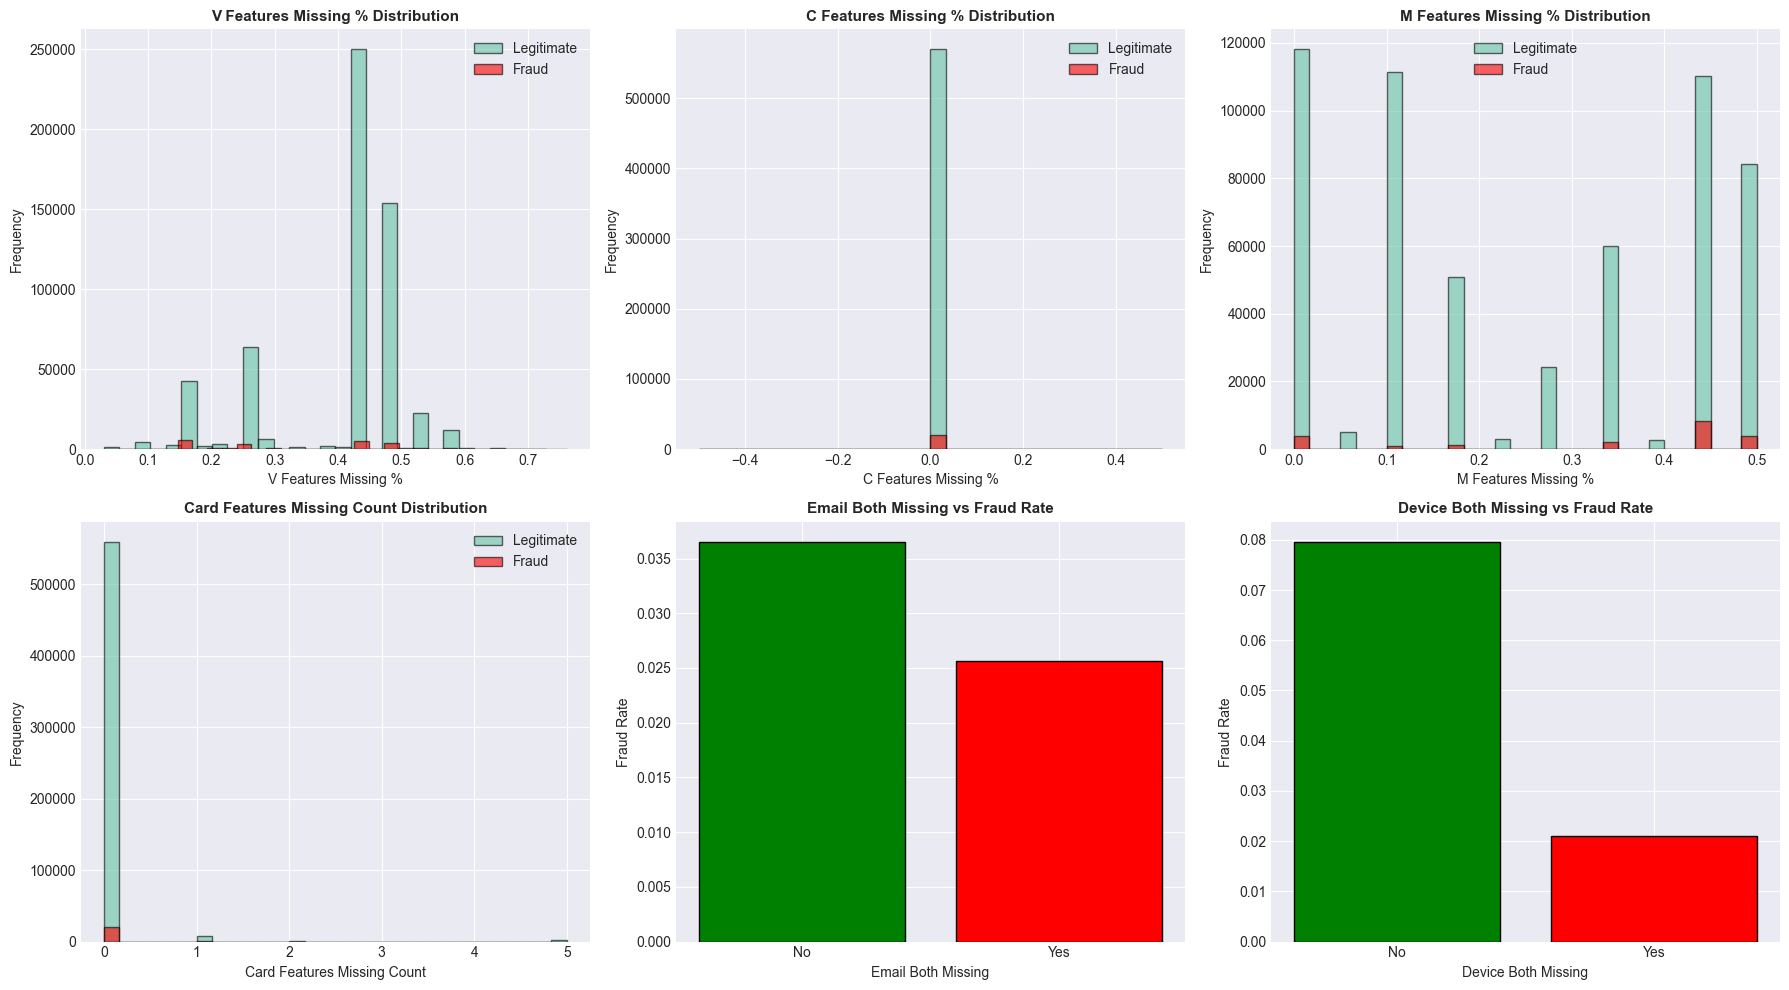

In [9]:
# Visualize key missing features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

key_features = [
    'V_missing_pct',
    'C_missing_pct',
    'M_missing_pct',
    'card_missing_count',
    'email_both_missing',
    'device_both_missing'
]

titles = [
    'V Features Missing %',
    'C Features Missing %',
    'M Features Missing %',
    'Card Features Missing Count',
    'Email Both Missing',
    'Device Both Missing'
]

for idx, (feat, title) in enumerate(zip(key_features, titles)):
    if feat in train_df_full.columns:
        ax = axes[idx // 3, idx % 3]
        
        # Plot by fraud status
        if train_df_full[feat].dtype in ['int64', 'int32'] and train_df_full[feat].nunique() == 2:
            # Binary feature - bar plot
            fraud_rate_0 = train_df_full[train_df_full[feat] == 0]['isFraud'].mean()
            fraud_rate_1 = train_df_full[train_df_full[feat] == 1]['isFraud'].mean()
            
            ax.bar([0, 1], [fraud_rate_0, fraud_rate_1], color=['green', 'red'], edgecolor='black')
            ax.set_xlabel(title, fontsize=10)
            ax.set_ylabel('Fraud Rate', fontsize=10)
            ax.set_title(f'{title} vs Fraud Rate', fontsize=11, fontweight='bold')
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['No', 'Yes'])
        else:
            # Continuous feature - histogram
            train_df_full[train_df_full['isFraud'] == 0][feat].hist(
                bins=30, ax=ax, alpha=0.6, label='Legitimate', edgecolor='black'
            )
            train_df_full[train_df_full['isFraud'] == 1][feat].hist(
                bins=30, ax=ax, alpha=0.6, label='Fraud', color='red', edgecolor='black'
            )
            ax.set_xlabel(title, fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.set_title(f'{title} Distribution', fontsize=11, fontweight='bold')
            ax.legend()

plt.tight_layout()
plt.show()

In [10]:
# Correlation analysis
print("Analyzing correlation with fraud target...\n")

# Calculate correlations for missing features
missing_numeric = [f for f in missing_feature_names 
                   if train_df_full[f].dtype in ['float64', 'int64', 'float32', 'int32']]

correlations = train_df_full[missing_numeric + ['isFraud']].corr()['isFraud'].drop('isFraud')
correlations = correlations.abs().sort_values(ascending=False)

print("Top 20 missing value features by correlation with fraud:")
print("="*70)
for i, (feat, corr) in enumerate(correlations.head(20).items(), 1):
    print(f"{i:2d}. {feat:50s} {corr:.6f}")
print("="*70)

Analyzing correlation with fraud target...

Top 20 missing value features by correlation with fraud:
 1. D7_ismissing                                       0.164478
 2. address_all_present                                0.159479
 3. addr1_ismissing                                    0.159479
 4. addr2_ismissing                                    0.159479
 5. address_both_missing                               0.159479
 6. D12_ismissing                                      0.157344
 7. D14_ismissing                                      0.151227
 8. card1_avg_missing                                  0.146834
 9. D6_ismissing                                       0.144233
10. D9_ismissing                                       0.144123
11. D8_ismissing                                       0.144123
12. D13_ismissing                                      0.140420
13. R_emaildomain_ismissing                            0.140127
14. ProductCD_avg_missing                              0.139667
15.

## 7. Prepare Data for Modeling

In [11]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df_full['isFraud']
X = train_df_full.drop(['isFraud', 'TransactionID'], axis=1)

print(f"Starting features: {X.shape[1]}")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

print("\nEncoding categorical features...")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_features)} categorical features")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
print("\nFilling missing values...")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print("✓ Data preparation complete")

Preparing data for modeling...

Starting features: 755

Encoding categorical features...
Starting features: 755

Encoding categorical features...
Found 59 categorical features
Found 59 categorical features

Filling missing values...

Filling missing values...

✓ Final feature count: 755
✓ Data preparation complete

✓ Final feature count: 755
✓ Data preparation complete


## 8. Train/Validation Split

In [12]:
# Time-based split
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"Features: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%
Features: 755

✓ Data split complete


## 9. Train Model with All Features

In [13]:
# Train model with all features (M7 + M8 + M9 + M10)
print("Training LightGBM with all features...\n")

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 256,
    'max_depth': 12,
    'min_child_samples': 50,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

model = LGBMBaseline(params=params)
metrics = model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

Training LightGBM with all features...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 755

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.988147	valid's auc: 0.976334
[100]	train's auc: 0.988147	valid's auc: 0.976334
[200]	train's auc: 0.992963	valid's auc: 0.979805
[200]	train's auc: 0.992963	valid's auc: 0.979805
[300]	train's auc: 0.995357	valid's auc: 0.981235
[300]	train's auc: 0.995357	valid's auc: 0.981235
[400]	train's auc: 0.996696	valid's auc: 0.982129
[400]	train's auc: 0.996696	valid's auc: 0.982129
[500]	train's auc: 0.99733	valid's auc: 0.982594
[500]	train's auc: 0.99733	valid's auc: 0.982594
[600]	train's auc: 0.997832	valid's auc: 0.982985
[600]	train's auc: 0.997832	valid's auc: 0.982985
[700]	train's auc: 0.99828	valid's auc: 0.983299
[700]	train

## 10. Evaluate Model

In [14]:
# Evaluate model
val_pred_proba = model.predict(X_val)

val_metrics = evaluate_model(y_val, val_pred_proba, threshold=0.5)
print_evaluation_metrics(val_metrics)

MODEL EVALUATION METRICS

ROC-AUC Score:     0.984151
Accuracy:          0.9855
Precision:         0.8973
Recall:            0.6538
F1-Score:          0.7564

Confusion Matrix:
  True Positives:  2,657
  False Positives: 304
  True Negatives:  113,740
  False Negatives: 1,407


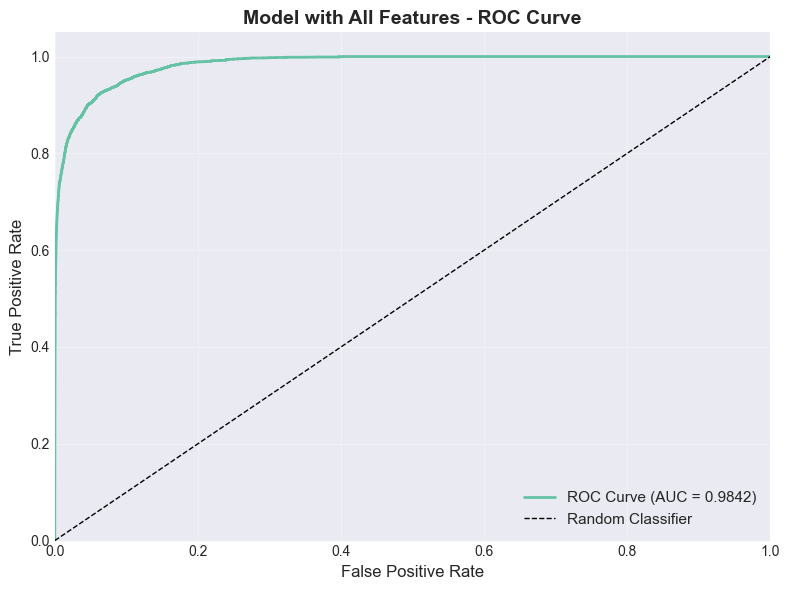

In [15]:
# Plot ROC curve
plot_roc_curve(y_val, val_pred_proba, title="Model with All Features - ROC Curve")

## 11. Feature Importance Analysis

In [16]:
# Get feature importance
importance_df = model.get_feature_importance(top_n=50)

# Count missing features in top 50
top_missing_features = [f for f in importance_df['feature'].tolist() 
                        if f in missing_feature_names]

print("="*70)
print("MISSING VALUE FEATURES IN TOP 50")
print("="*70)
print(f"\nMissing value features in top 50: {len(top_missing_features)}")
print(f"Percentage: {len(top_missing_features)/50*100:.1f}%")
if top_missing_features:
    print("\nTop missing value features:")
    for i, feat in enumerate(top_missing_features[:15], 1):
        rank = importance_df[importance_df['feature'] == feat].index[0] + 1
        imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
        print(f"  {i:2d}. #{rank:2d} {feat:45s} {imp:,.0f}")
print("="*70)

MISSING VALUE FEATURES IN TOP 50

Missing value features in top 50: 0
Percentage: 0.0%


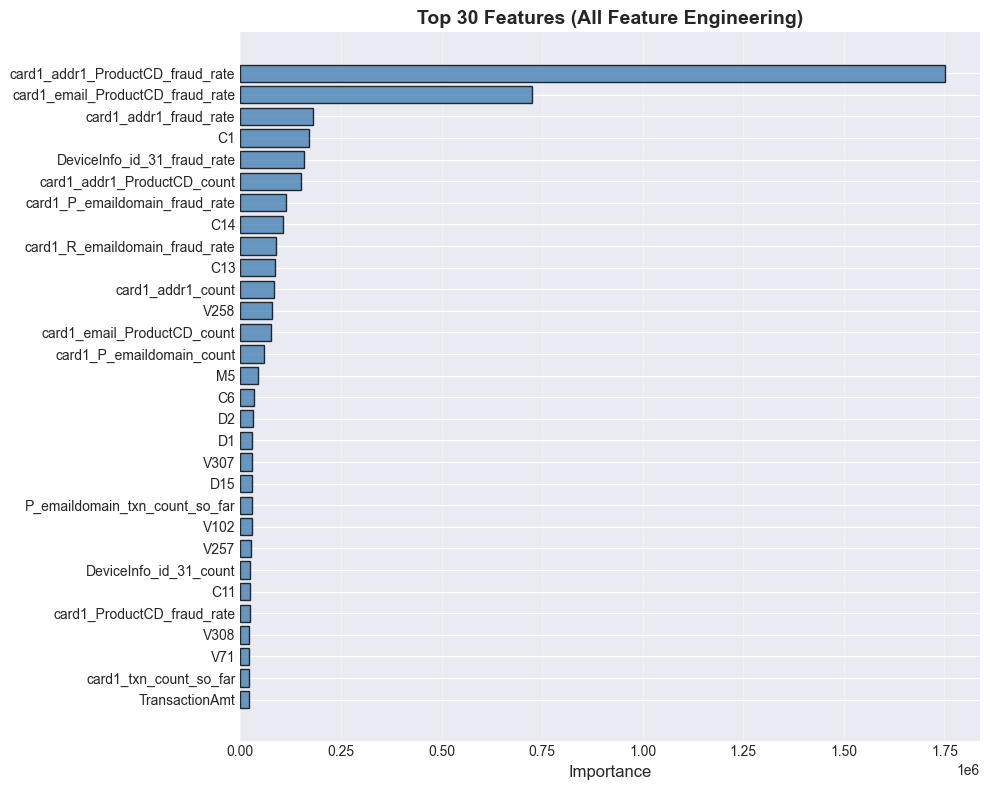

In [17]:
# Plot feature importance
plot_feature_importance(
    model.feature_importance,
    top_n=30,
    title="Top 30 Features (All Feature Engineering)"
)

## 12. Performance Comparison

PERFORMANCE COMPARISON

Baseline Model (M5):               0.900000
Enhanced Model (M6):                0.920000
With Aggregations (M7):             0.925000
With Interactions (M8):             0.930000
With Temporal (M9):                 0.935000
With Missing Features (M10):        0.984151

Improvement over baseline:          +0.084151
Improvement over temporal:          +0.049151

Target (Top 10%):                   0.945000
Gap to target:                       -0.039151


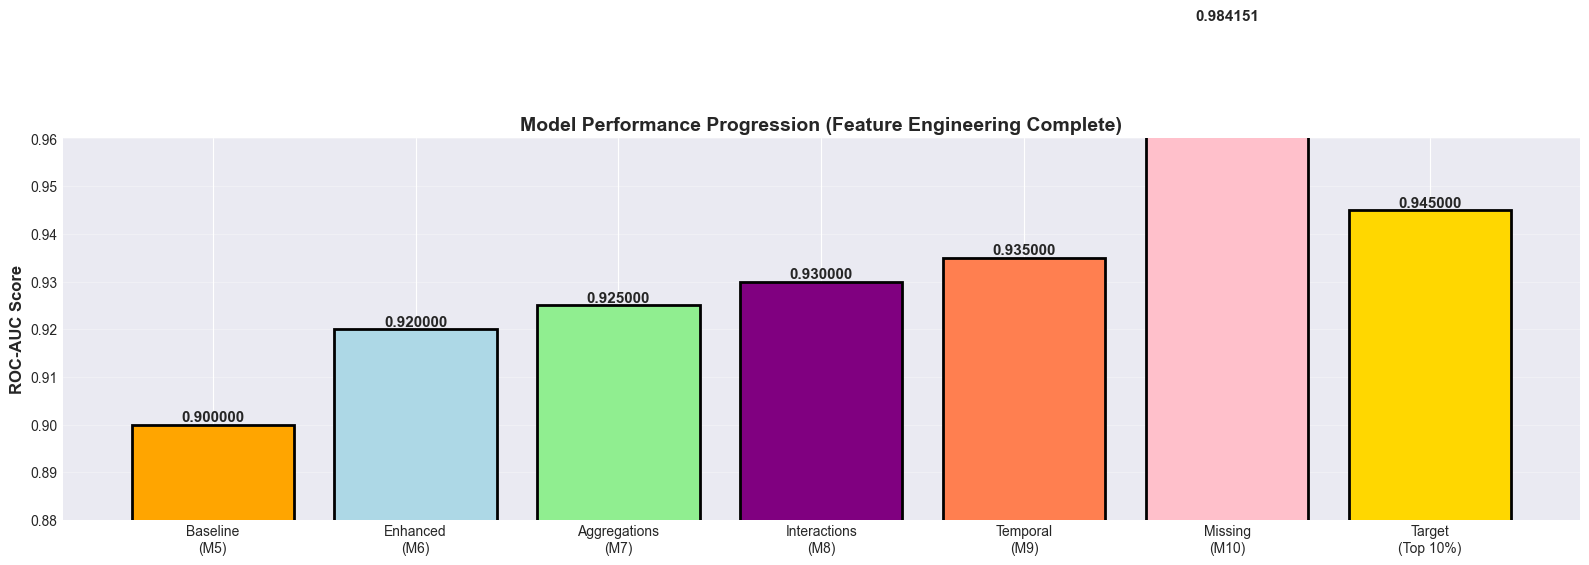

In [18]:
# Compare with previous results
baseline_auc = 0.90  # Update with actual
enhanced_auc = 0.92  # Update with actual (M6)
aggregation_auc = 0.925  # Update with actual (M7)
interaction_auc = 0.930  # Update with actual (M8)
temporal_auc = 0.935  # Update with actual (M9)
missing_auc = metrics['val_auc']

print("="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(f"\nBaseline Model (M5):               {baseline_auc:.6f}")
print(f"Enhanced Model (M6):                {enhanced_auc:.6f}")
print(f"With Aggregations (M7):             {aggregation_auc:.6f}")
print(f"With Interactions (M8):             {interaction_auc:.6f}")
print(f"With Temporal (M9):                 {temporal_auc:.6f}")
print(f"With Missing Features (M10):        {missing_auc:.6f}")
print(f"\nImprovement over baseline:          +{(missing_auc - baseline_auc):.6f}")
print(f"Improvement over temporal:          +{(missing_auc - temporal_auc):.6f}")
print(f"\nTarget (Top 10%):                   0.945000")
print(f"Gap to target:                       {(0.945 - missing_auc):.6f}")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(16, 6))

models = ['Baseline\n(M5)', 'Enhanced\n(M6)', 'Aggregations\n(M7)', 
          'Interactions\n(M8)', 'Temporal\n(M9)', 'Missing\n(M10)', 'Target\n(Top 10%)']
scores = [baseline_auc, enhanced_auc, aggregation_auc, interaction_auc, 
          temporal_auc, missing_auc, 0.945]
colors = ['orange', 'lightblue', 'lightgreen', 'purple', 'coral', 'pink', 'gold']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Progression (Feature Engineering Complete)', fontsize=14, fontweight='bold')
ax.set_ylim(0.88, 0.96)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 13. Feature Category Breakdown

FEATURE CATEGORY BREAKDOWN IN TOP 50

Original features:      24 ( 48.0%)
Missing features:        0 (  0.0%)
Aggregation features:    6 ( 12.0%)
Interaction features:   15 ( 30.0%)
Temporal features:       5 ( 10.0%)


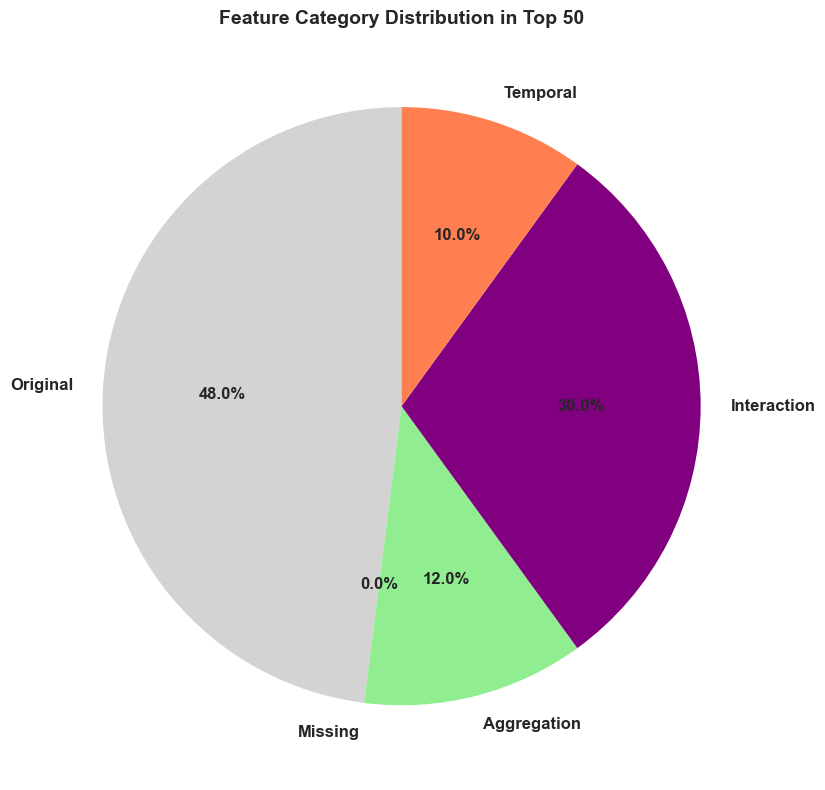

In [19]:
# Analyze contribution of each feature category
all_features = importance_df['feature'].tolist()

# Categorize features
original_features = [f for f in all_features if f not in missing_feature_names + agg_feature_names + interaction_feature_names + temporal_feature_names]
missing_in_top50 = [f for f in all_features if f in missing_feature_names]
agg_in_top50 = [f for f in all_features if f in agg_feature_names]
interaction_in_top50 = [f for f in all_features if f in interaction_feature_names]
temporal_in_top50 = [f for f in all_features if f in temporal_feature_names]

print("="*70)
print("FEATURE CATEGORY BREAKDOWN IN TOP 50")
print("="*70)
print(f"\nOriginal features:      {len(original_features):2d} ({len(original_features)/50*100:5.1f}%)")
print(f"Missing features:       {len(missing_in_top50):2d} ({len(missing_in_top50)/50*100:5.1f}%)")
print(f"Aggregation features:   {len(agg_in_top50):2d} ({len(agg_in_top50)/50*100:5.1f}%)")
print(f"Interaction features:   {len(interaction_in_top50):2d} ({len(interaction_in_top50)/50*100:5.1f}%)")
print(f"Temporal features:      {len(temporal_in_top50):2d} ({len(temporal_in_top50)/50*100:5.1f}%)")
print("="*70)

# Pie chart
fig, ax = plt.subplots(figsize=(10, 8))
categories = ['Original', 'Missing', 'Aggregation', 'Interaction', 'Temporal']
counts = [len(original_features), len(missing_in_top50), len(agg_in_top50), 
          len(interaction_in_top50), len(temporal_in_top50)]
colors_pie = ['lightgray', 'pink', 'lightgreen', 'purple', 'coral']

ax.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, 
       colors=colors_pie, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Feature Category Distribution in Top 50', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. Save Model

In [20]:
# Save model
import os

os.makedirs('../models', exist_ok=True)
model.save_model('../models/lgbm_all_features.txt')

print("✓ Model saved successfully!")

✓ Model saved: ../models/lgbm_all_features.txt
✓ Metadata saved: ../models/lgbm_all_features_metadata.json
✓ Model saved successfully!


## 15. Summary

In [21]:
print("="*70)
print("PHASE 3: FEATURE ENGINEERING - COMPLETE")
print("="*70)

print("\n📊 FEATURES CREATED:")
print(f"  • Missing value features: {len(missing_feature_names)}")
print(f"  • Aggregation features: {len(agg_feature_names)}")
print(f"  • Interaction features: {len(interaction_feature_names)}")
print(f"  • Temporal features: {len(temporal_feature_names)}")
print(f"  • Total features in model: {X.shape[1]}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"  • Validation AUC: {missing_auc:.6f}")
print(f"  • Training AUC: {metrics['train_auc']:.6f}")
print(f"  • Improvement over baseline: +{(missing_auc - baseline_auc):.6f}")
print(f"  • Gap to Top 10%: {(0.945 - missing_auc):.6f}")

print("\n✅ MILESTONES 7-10 COMPLETE:")
print("  ✓ M7: Aggregation features (card, email, device, product, address)")
print("  ✓ M8: Interaction features (combinations + fraud rates)")
print("  ✓ M9: Temporal features (time-since, velocity, RFM, patterns)")
print("  ✓ M10: Missing value features (patterns, co-occurrence, anomalies)")

print("\n🚀 NEXT STEPS (Phase 4: Model Optimization):")
print("  • M11: Hyperparameter tuning (learning rate, depth, leaves)")
print("  • M12: Feature selection (remove redundant/low-importance features)")
print("  • M13: Advanced modeling (stacking, blending, ensembles)")
print("  • Target: Reach 0.945+ ROC-AUC (Top 10%)")

print("\n" + "="*70)
print("✓ FEATURE ENGINEERING PHASE COMPLETE")
print("="*70)

PHASE 3: FEATURE ENGINEERING - COMPLETE

📊 FEATURES CREATED:
  • Missing value features: 104
  • Aggregation features: 71
  • Interaction features: 70
  • Temporal features: 75
  • Total features in model: 755

🎯 MODEL PERFORMANCE:
  • Validation AUC: 0.984151
  • Training AUC: 0.999845
  • Improvement over baseline: +0.084151
  • Gap to Top 10%: -0.039151

✅ MILESTONES 7-10 COMPLETE:
  ✓ M7: Aggregation features (card, email, device, product, address)
  ✓ M8: Interaction features (combinations + fraud rates)
  ✓ M9: Temporal features (time-since, velocity, RFM, patterns)
  ✓ M10: Missing value features (patterns, co-occurrence, anomalies)

🚀 NEXT STEPS (Phase 4: Model Optimization):
  • M11: Hyperparameter tuning (learning rate, depth, leaves)
  • M12: Feature selection (remove redundant/low-importance features)
  • M13: Advanced modeling (stacking, blending, ensembles)
  • Target: Reach 0.945+ ROC-AUC (Top 10%)

✓ FEATURE ENGINEERING PHASE COMPLETE
